## Data collection



In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

# Create a directory to store data
output_dir = "financial_data"
os.makedirs(output_dir, exist_ok=True)

# Define time range
end_date = "2025-02-28"
start_date = "2014-01-02"

# Define tickers for Yahoo Finance
tickers = {
    "Brent_Crude": "BZ=F",       # Brent Crude Oil Futures
    "Natural_Gas": "NG=F",       # Natural Gas Futures
    "NOK_USD": "NOK=X",          # NOK/USD Exchange Rate
    "OSEBX": "^OSEAX",           # OSEBX Index
    "Aker_BP": "AKRBP.OL"       # Aker BP Stock Price
}

# Function to fetch data and store in a single CSV per asset


def fetch_yahoo_data(ticker, name):
    try:
        # Fetch stock data
        data = yf.download(ticker, start=start_date,
                           end=end_date, progress=False, auto_adjust=False)

        if data.empty:
            print(f"Warning: No data for {name} ({ticker})")
            return None

        # Compute log returns
        data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))

        # Reset index to ensure 'Date' is included as a column
        data = data.reset_index()

        # Drop 'Adj Close' if it exists
        if "Adj Close" in data.columns:
            data = data.drop(columns=["Adj Close"])

        # Check if the second row is a duplicate ticker row and remove it
        # If the second row is text instead of numbers
        if isinstance(data.iloc[0, 1], str):
            data = data.iloc[1:].reset_index(drop=True)

        # Ensure column names are correctly assigned
        expected_columns = ["Date", "Close", "High",
                            "Low", "Open", "Volume", "Log_Returns"]
        if len(data.columns) == len(expected_columns):
            data.columns = expected_columns

        # Save the cleaned dataset
        file_path = os.path.join(output_dir, f"{name}.csv")
        data.to_csv(file_path, index=False)
        print(f"Saved {file_path} (Clean Data)")

        return data

    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")
        return None


# Fetch and save Yahoo Finance data
for key, ticker in tickers.items():
    fetch_yahoo_data(ticker, key)

# Fetch Interest Rates


def fetch_interest_rates():
    ir_tickers = {
        "US_10Yr_Treasury": "^TNX",  # US 10-Year Treasury Yield
    }
    for key, ticker in ir_tickers.items():
        fetch_yahoo_data(ticker, key)


fetch_interest_rates()

print("\nData collection complete. Each asset has its own CSV file in 'financial_data'. Existing files are overwritten.")


Saved financial_data\Brent_Crude.csv (Clean Data)
Saved financial_data\Natural_Gas.csv (Clean Data)
Saved financial_data\NOK_USD.csv (Clean Data)
Saved financial_data\OSEBX.csv (Clean Data)
Saved financial_data\Aker_BP.csv (Clean Data)
Saved financial_data\US_10Yr_Treasury.csv (Clean Data)

Data collection complete. Each asset has its own CSV file in 'financial_data'. Existing files are overwritten.


## Data transformation

In [26]:
import os
import calendar


# Lists of CSV input filenames and corresponding output CSV filenames
input_files = ['Aker_BP.csv', 'Brent_Crude.csv', 'Natural_Gas.csv', 'NOK_USD.csv', 'OSEBX.csv', 'US_10Yr_Treasury.csv']  
output_files = ['Aker_BP_weekly', 'Brent_Crude_weekly', 'Natural_Gas_weekly','NOK_USD_weekly', 'OSEBX_weekly', 'US_10Yr_Treasury_weekly'] 

# Loop through each input file
for input_file, output_file in zip(input_files, output_files):
    # Load the CSV file into a DataFrame
    input_file_path = os.path.join('financial_data', input_file)
    df = pd.read_csv(input_file_path)

    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)
    
    # Create new columns for the year and week number
    df['Year'] = df.index.year
    df['Week'] = df.index.isocalendar().week

    # Resample the data to weekly frequency, using mean for all the number columns
    df_weekly = df.resample('W').agg({
    'Close': 'mean',  
    'High': 'mean', 
    'Low': 'mean',
    'Open': 'mean',
    'Volume': 'mean',
    'Log_Returns': 'mean',
    'Week': 'first',         
    'Year': 'last'             
})
    # Formatting the csv. file
    df_weekly['Date'] = df_weekly['Year'].astype(int).astype(str) + '-' + df_weekly['Week'].astype(int).astype(str).str.zfill(2) # Change the 'Date' column to have the format yyyy-weekNo.
    df_weekly = df_weekly.drop(columns=['Year', 'Week']) # Remove columns 'Year' and 'Week that were used to format the 'Date' column
    columns = df_weekly.columns.tolist() 
    columns = columns[-1:] + columns[:-1] # Put the 'Date' column first
    df_weekly = df_weekly[columns] 

    # Save the transformed weekly data to a new CSV file
    file_path = os.path.join('financial_data', f"{output_file}.csv")
    df_weekly.to_csv(file_path, index=False)

    print(f"Processed {input_file} and saved as {output_file}")
    
# The same procedure as above for the Norwegian policy rate that has different columns that the csv files above
input_file_path = os.path.join('financial_data', 'Norwegian_Policy_Rate.csv')
df = pd.read_csv(input_file_path)

# Convert the 'Date' column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Create new columns for the year and week number
df['Year'] = df.index.year
df['Week'] = df.index.isocalendar().week

# Resample the data to weekly frequency, using the last rate of the week
df_weekly = df.resample('W').agg({
'Rate': 'last',  
'Week': 'first',        
'Year': 'last'             
})

# Formatting the csv. file
df_weekly['Date'] = df_weekly['Year'].astype(int).astype(str) + '-' + df_weekly['Week'].astype(int).astype(str).str.zfill(2) # Change the 'Date' column to have the format yyyy-weekNo.
df_weekly = df_weekly.drop(columns=['Year', 'Week']) # Remove columns 'Year' and 'Week that were used to format the 'Date' column
columns = df_weekly.columns.tolist()
columns = columns[-1:] + columns[:-1] # Put the 'Date' column first
df_weekly = df_weekly[columns] 

# Save the transformed weekly data to a new CSV file
file_path = os.path.join('financial_data', f"Norwegian_Policy_Rate_weekly.csv")
df_weekly.to_csv(file_path, index=False)

print(f"Processed Norwegian_Policy_Rate and saved as Norwegian_Policy_Rate_weekly")

# The same procedure as above for the CPI rate that has different columns that the csv files above and consist of monthly data and not daily
# Load CPI monthly data
input_file_path = os.path.join('financial_data', 'CPI_Rate.csv')
df_monthly = pd.read_csv(input_file_path)
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly.set_index('Date', inplace=True)

# Create a new weekly date range from the start to the end of data
start_date = df_monthly.index.min()
end_date = pd.to_datetime('2025-03-03')  # ensure it includes week 9
weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-WED')

# Prepare a new DataFrame to store weekly CPI rates
weekly_data = []

for date, row in df_monthly.iterrows():
    year = date.year
    month = date.month

    # Calculate number of weeks in the month
    first_day = pd.Timestamp(year=year, month=month, day=1)
    last_day = pd.Timestamp(year=year, month=month, day=calendar.monthrange(year, month)[1])
    weeks_in_month = len(pd.date_range(start=first_day, end=last_day, freq='W'))

    # Compute equivalent weekly rate using compound rate approximation
    monthly_rate = row['Rate']
    weekly_rate = (1 + monthly_rate)**(1 / weeks_in_month) - 1

    # Get all weekly index within this month
    weekly_dates_in_month = [d for d in weekly_dates if d >= first_day and d <= last_day]

    for d in weekly_dates_in_month:
        weekly_data.append({'Date': d, 'Rate': weekly_rate})

# Formatting the csv. file
df_weekly = pd.DataFrame(weekly_data) # Convert to DataFrame
df_weekly['Year'] = df_weekly['Date'].dt.year # Add year and ISO week number
df_weekly['Week'] = df_weekly['Date'].dt.isocalendar().week # Add year and ISO week number
df_weekly['Date'] = df_weekly['Year'].astype(str) + '-' + df_weekly['Week'].astype(str).str.zfill(2) # Format date to yyyy-weekNo.
df_weekly = df_weekly[['Date', 'Rate']] # Rearrange and remove extra columns

# Save the transformed weekly data to a new CSV file
output_file_path = os.path.join('financial_data', 'CPI_Rate_weekly.csv')
df_weekly.to_csv(output_file_path, index=False)

print("Processed CPI_Rate and saved as CPI_Rate_weekly")

Processed Aker_BP.csv and saved as Aker_BP_weekly
Processed Brent_Crude.csv and saved as Brent_Crude_weekly
Processed Natural_Gas.csv and saved as Natural_Gas_weekly
Processed NOK_USD.csv and saved as NOK_USD_weekly
Processed OSEBX.csv and saved as OSEBX_weekly
Processed US_10Yr_Treasury.csv and saved as US_10Yr_Treasury_weekly
Processed Norwegian_Policy_Rate and saved as Norwegian_Policy_Rate_weekly
Processed CPI_Rate and saved as CPI_Rate_weekly


## Visualisation of the data

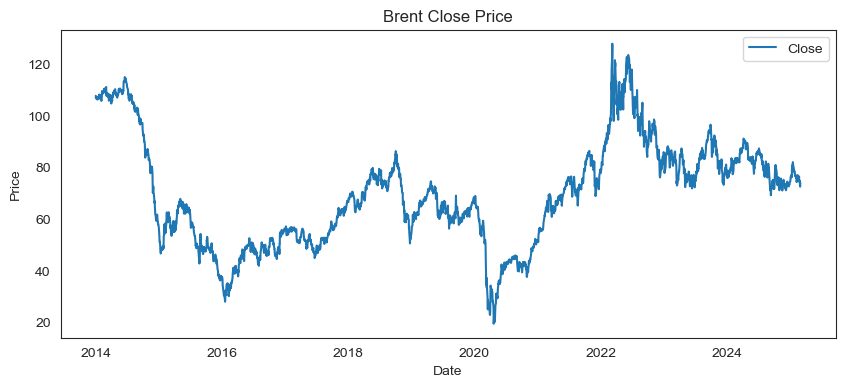

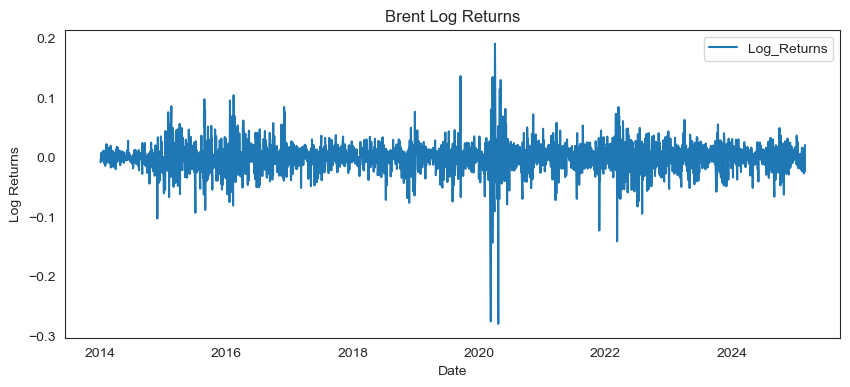

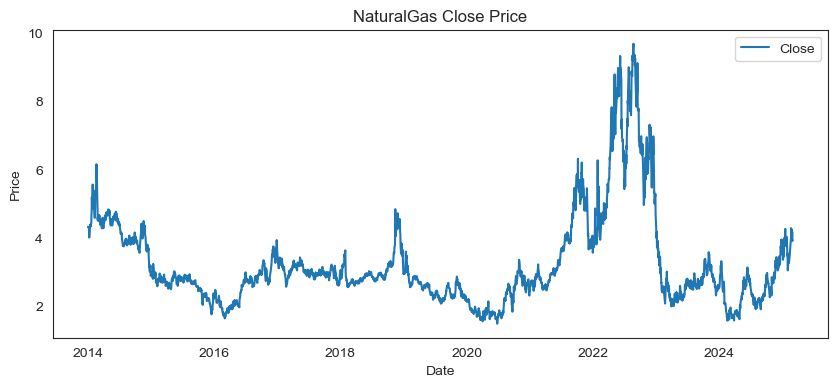

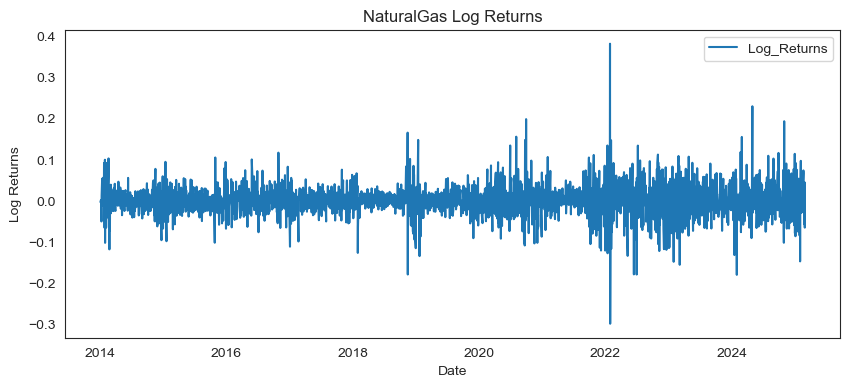

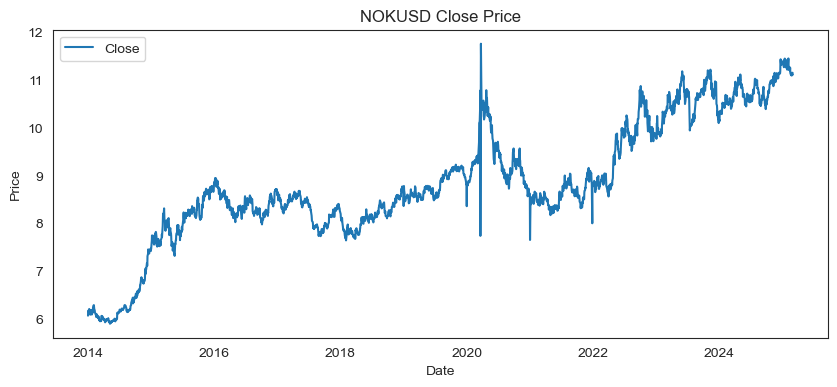

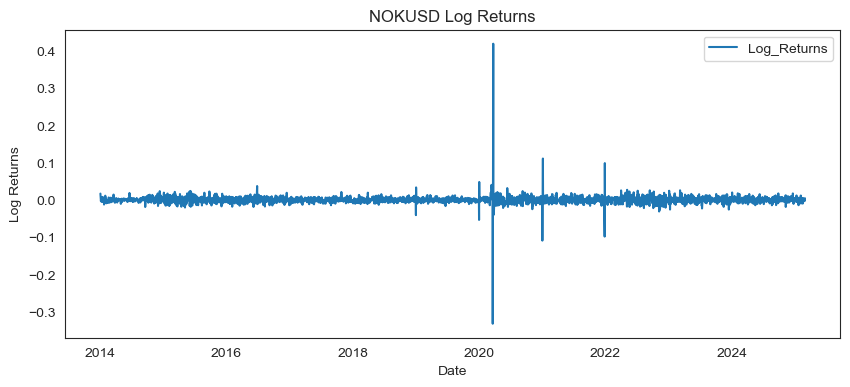

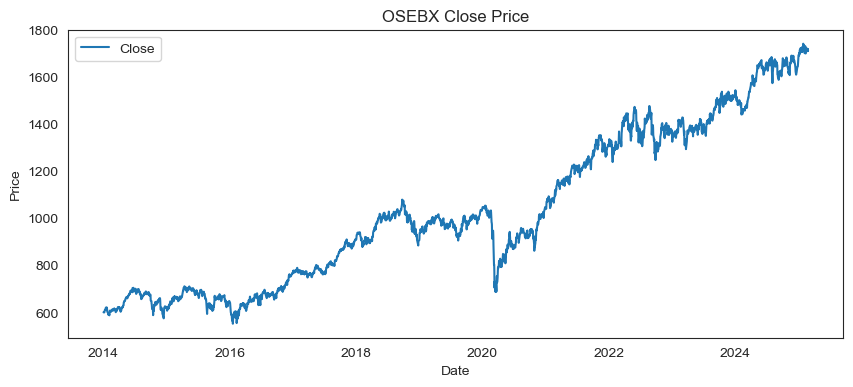

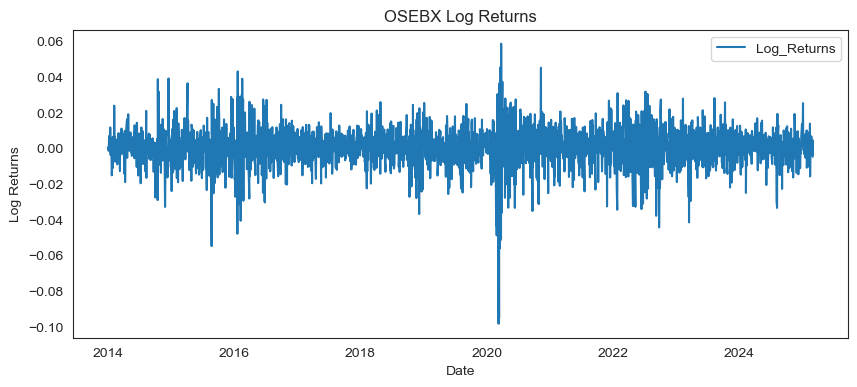

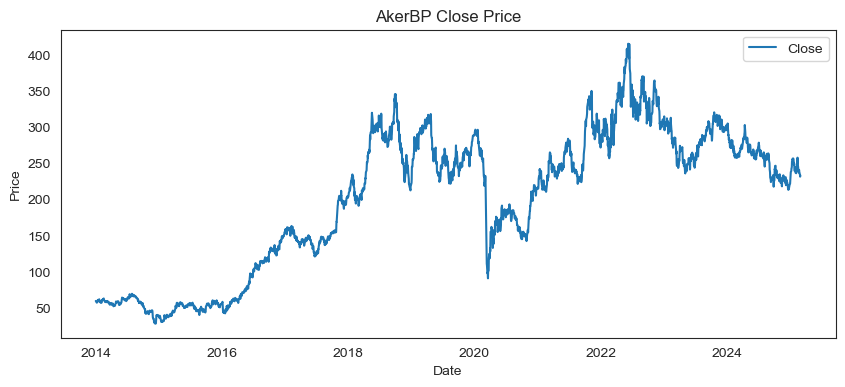

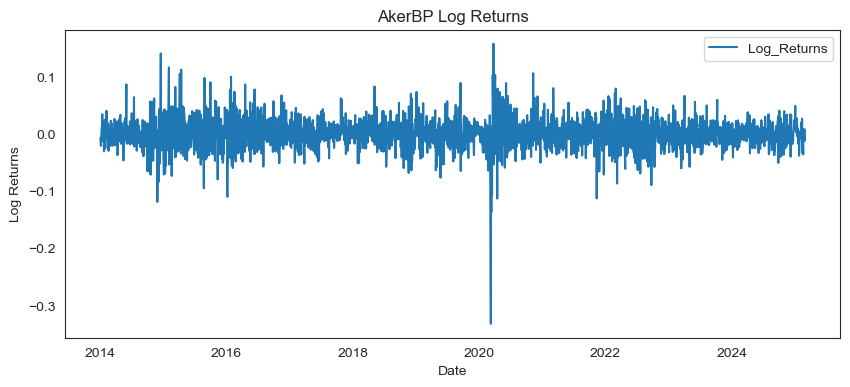

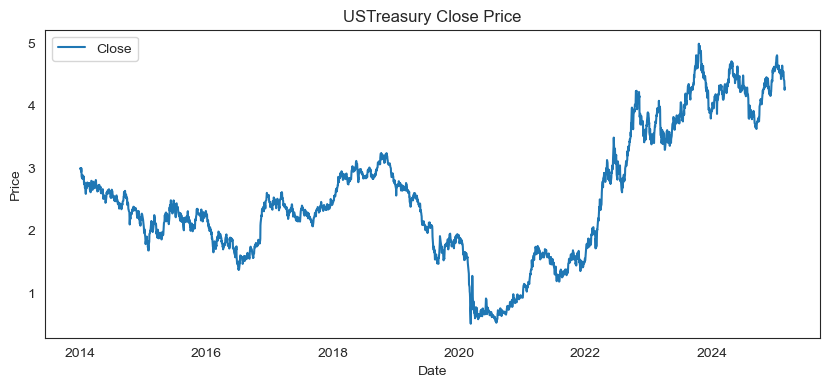

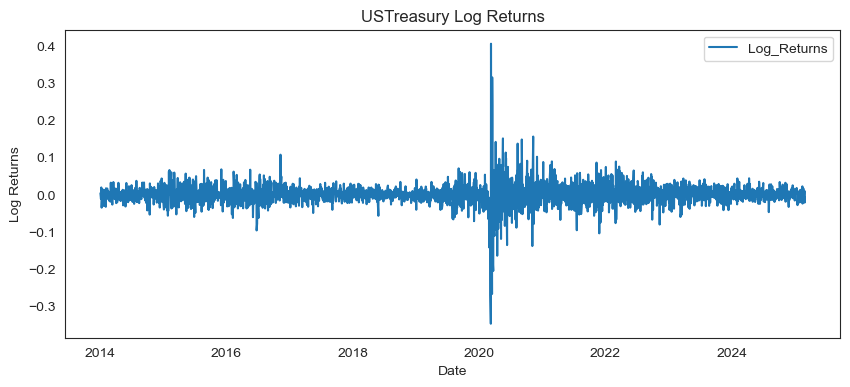

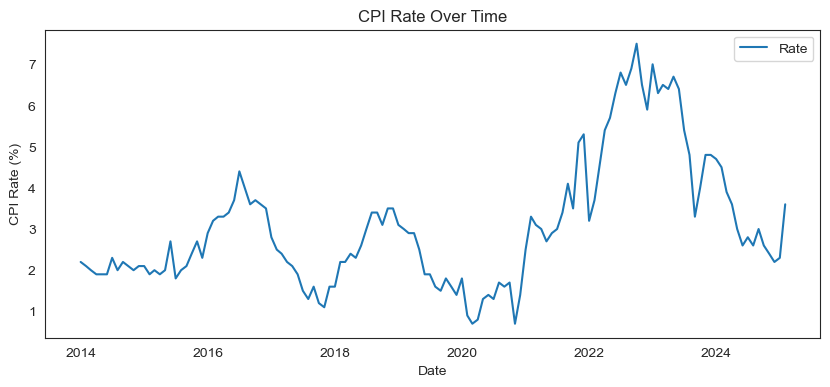

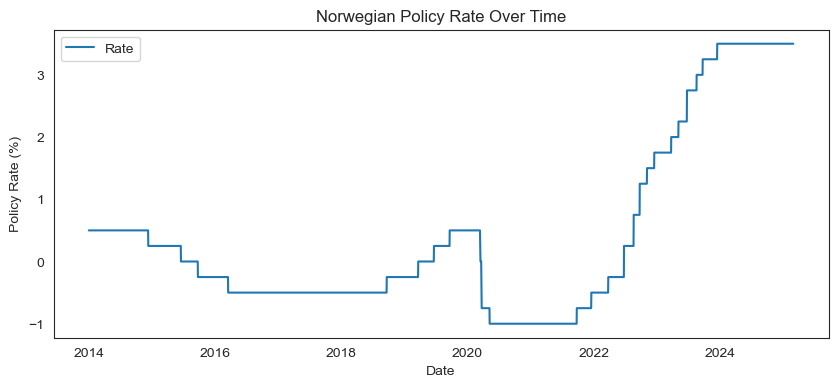

ADF Test for Brent Close
Test Statistic: -2.3004
P-value: 0.1718
=> Likely non-stationary.

ADF Test for Brent Log Returns
Test Statistic: -10.9039
P-value: 0.0000
=> Likely stationary.

ADF Test for NaturalGas Close
Test Statistic: -2.9762
P-value: 0.0372
=> Likely stationary.

ADF Test for NaturalGas Log Returns
Test Statistic: -17.1769
P-value: 0.0000
=> Likely stationary.

ADF Test for NOKUSD Close
Test Statistic: -1.5615
P-value: 0.5029
=> Likely non-stationary.

ADF Test for NOKUSD Log Returns
Test Statistic: -40.6595
P-value: 0.0000
=> Likely stationary.

ADF Test for OSEBX Close
Test Statistic: 0.0182
P-value: 0.9600
=> Likely non-stationary.

ADF Test for OSEBX Log Returns
Test Statistic: -16.9319
P-value: 0.0000
=> Likely stationary.

ADF Test for AkerBP Close
Test Statistic: -1.9013
P-value: 0.3314
=> Likely non-stationary.

ADF Test for AkerBP Log Returns
Test Statistic: -15.2230
P-value: 0.0000
=> Likely stationary.

ADF Test for USTreasury Close
Test Statistic: -0.8921
P-

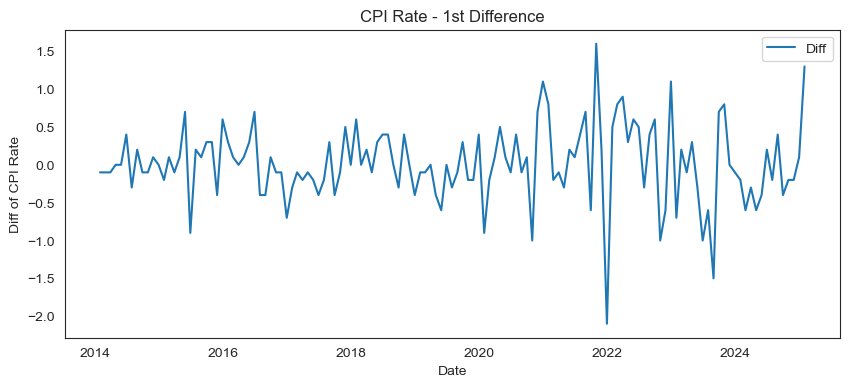

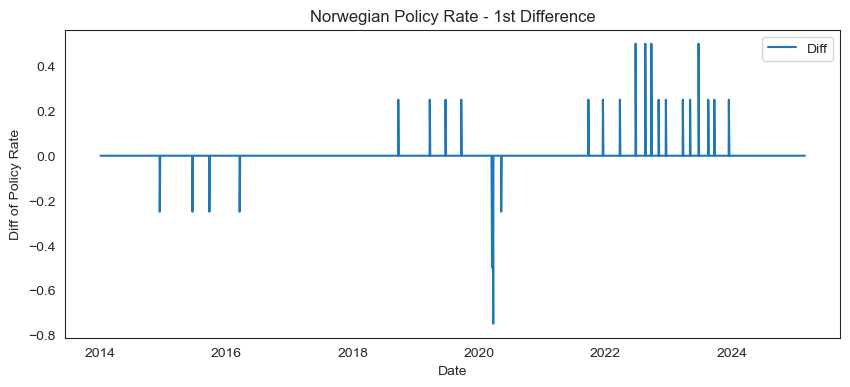

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Define directory and file names for daily data
data_dir = "financial_data"
file_names = {
    "Brent": "Brent_Crude.csv",
    "NaturalGas": "Natural_Gas.csv",
    "NOKUSD": "NOK_USD.csv",
    "OSEBX": "OSEBX.csv",
    "AkerBP": "Aker_BP.csv",
    "USTreasury": "US_10Yr_Treasury.csv"
}

# Load monthly datasets (CPI and Policy Rate)
cpi_df = pd.read_csv(os.path.join(data_dir, "CPI_rate.csv"), parse_dates=["Date"])
policy_df = pd.read_csv(os.path.join(data_dir, "Norwegian_Policy_Rate.csv"), parse_dates=["Date"])

# Sort monthly data
cpi_df.sort_values("Date", inplace=True)
policy_df.sort_values("Date", inplace=True)

# Load the daily data into a dictionary of DataFrames
data_dict = {}
for key, file in file_names.items():
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df.sort_values("Date", inplace=True)
    data_dict[key] = df


# Visualisation of the data
# Function to plot a time series
def plot_series(df, date_col, value_col, title, ylabel):
    plt.figure(figsize=(10, 4))
    plt.plot(df[date_col], df[value_col], label=value_col)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Visualize daily data: Plot both Close and Log Returns for each asset
for key, df in data_dict.items():
    plot_series(df, "Date", "Close", f"{key} Close Price", "Price")
    plot_series(df, "Date", "Log_Returns", f"{key} Log Returns", "Log Returns")

# Visualize monthly data: CPI and Policy Rate (raw)
plot_series(cpi_df, "Date", "Rate", "CPI Rate Over Time", "CPI Rate (%)")
plot_series(policy_df, "Date", "Rate", "Norwegian Policy Rate Over Time", "Policy Rate (%)")


def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f"ADF Test for {title}")
    print(f"Test Statistic: {result[0]:.4f}")
    print(f"P-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("=> Likely stationary.\n")
    else:
        print("=> Likely non-stationary.\n")

# Daily Data: Test stationarity for both Close prices and Log Returns
for key, df in data_dict.items():
    adf_test(df["Close"], title=f"{key} Close")
    adf_test(df["Log_Returns"], title=f"{key} Log Returns")

# Monthly Data: Test stationarity for the raw Rate series
adf_test(cpi_df["Rate"], title="CPI Rate")
adf_test(policy_df["Rate"], title="Norwegian Policy Rate")

# Since CPI and Policy Rate are non-stationary, we difference them.
cpi_df["Diff"] = cpi_df["Rate"].diff()
policy_df["Diff"] = policy_df["Rate"].diff()

# Test stationarity again on the differenced series
adf_test(cpi_df["Diff"], title="CPI Rate - 1st Difference")
adf_test(policy_df["Diff"], title="Policy Rate - 1st Difference")

# Visualize the differenced (stationary) monthly data
plot_series(cpi_df, "Date", "Diff", "CPI Rate - 1st Difference", "Diff of CPI Rate")
plot_series(policy_df, "Date", "Diff", "Norwegian Policy Rate - 1st Difference", "Diff of Policy Rate")


## Regression analysis and data tests

ADF Test for Log_Returns_Aker_BP:
ADF Statistic: -10.406619746604214
p-value: 1.8496716480863245e-18
Critical Values:
   1%: -3.441753961421302
   5%: -2.866570853087291
   10%: -2.5694492998890817
Log_Returns_Aker_BP is stationary (p-value < 0.05)

ADF Test for Log_Returns_Brent_Crude:
ADF Statistic: -22.945440772935584
p-value: 0.0
Critical Values:
   1%: -3.4416749612171467
   5%: -2.8665360672844318
   10%: -2.5694307639714626
Log_Returns_Brent_Crude is stationary (p-value < 0.05)

ADF Test for Log_Returns_Natural_Gas:
ADF Statistic: -24.544996037342525
p-value: 0.0
Critical Values:
   1%: -3.4416749612171467
   5%: -2.8665360672844318
   10%: -2.5694307639714626
Log_Returns_Natural_Gas is stationary (p-value < 0.05)

ADF Test for Log_Returns_NOK_USD:
ADF Statistic: -8.146209042803047
p-value: 9.97320091620785e-13
Critical Values:
   1%: -3.441874550188182
   5%: -2.8666239496633246
   10%: -2.569477593105571
Log_Returns_NOK_USD is stationary (p-value < 0.05)

ADF Test for CPI_Rate

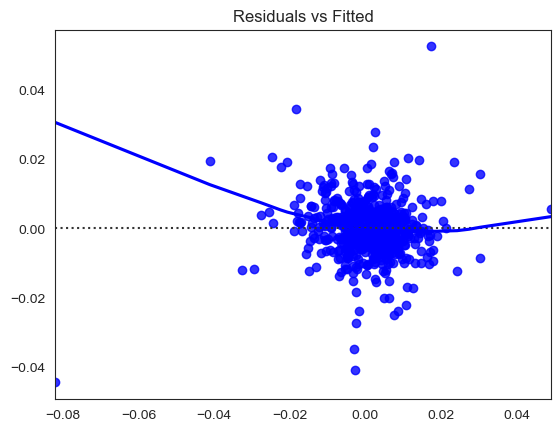

In [28]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.api import add_constant
import statsmodels.api as sm

# Function to perform Augmented Dickey-Fuller test and check for stationarity
def check_stationarity(series, name):
    adf_result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')
    if adf_result[1] < 0.05:
        print(f"{name} is stationary (p-value < 0.05)\n")
    else:
        print(f"{name} is not stationary (p-value >= 0.05)\n")

# Load the CSV files into DataFrames
df_aker_bp = pd.read_csv("financial_data/Aker_BP_weekly.csv")
df_brent_crude = pd.read_csv("financial_data/Brent_Crude_weekly.csv")
df_cpi_rate = pd.read_csv("financial_data/CPI_Rate_weekly.csv")
df_natural_gas = pd.read_csv("financial_data/Natural_Gas_Weekly.csv")
df_nok_usd = pd.read_csv("financial_data/NOK_USD_weekly.csv")
df_norwegian_policy_rate = pd.read_csv("financial_data/Norwegian_Policy_Rate_weekly.csv")
df_osebx = pd.read_csv("financial_data/OSEBX_weekly.csv")
df_us_treasury = pd.read_csv("financial_data/US_10Yr_Treasury_weekly.csv")

# Rename the conflicting columns (columns with the same names)
df_aker_bp = df_aker_bp.rename(columns={'Log_Returns': 'Log_Returns_Aker_BP'})
df_brent_crude = df_brent_crude.rename(columns={'Log_Returns': 'Log_Returns_Brent_Crude'})
df_natural_gas = df_natural_gas.rename(columns={'Log_Returns': 'Log_Returns_Natural_Gas'})
df_nok_usd = df_nok_usd.rename(columns={'Log_Returns': 'Log_Returns_NOK_USD'})
df_osebx = df_osebx.rename(columns={'Log_Returns': 'Log_Returns_OSEBX'})
df_us_treasury = df_us_treasury.rename(columns={'Log_Returns': 'Log_Returns_US_Treasury'})
df_cpi_rate = df_cpi_rate.rename(columns={'Rate': 'CPI_Rate'})
df_norwegian_policy_rate = df_norwegian_policy_rate.rename(columns={'Rate': 'Policy_Rate'})

# Merge all the dataframes on 'Date' 
df = df_aker_bp[['Date', 'Log_Returns_Aker_BP']] 
df = pd.merge(df, df_brent_crude[['Date', 'Log_Returns_Brent_Crude']], on='Date', how='inner')
df = pd.merge(df, df_cpi_rate[['Date', 'CPI_Rate']], on='Date', how='inner')
df = pd.merge(df, df_natural_gas[['Date', 'Log_Returns_Natural_Gas']], on='Date', how='inner')
df = pd.merge(df, df_nok_usd[['Date', 'Log_Returns_NOK_USD']], on='Date', how='inner')
df = pd.merge(df, df_norwegian_policy_rate[['Date', 'Policy_Rate']], on='Date', how='inner')
df = pd.merge(df, df_osebx[['Date', 'Log_Returns_OSEBX']], on='Date', how='inner')
df = pd.merge(df, df_us_treasury[['Date', 'Log_Returns_US_Treasury']], on='Date', how='inner')

# Check stationarity for each of the key variables
check_stationarity(df['Log_Returns_Aker_BP'], 'Log_Returns_Aker_BP')
check_stationarity(df['Log_Returns_Brent_Crude'], 'Log_Returns_Brent_Crude')
check_stationarity(df['Log_Returns_Natural_Gas'], 'Log_Returns_Natural_Gas')
check_stationarity(df['Log_Returns_NOK_USD'], 'Log_Returns_NOK_USD')
check_stationarity(df['CPI_Rate'], 'CPI_Rate')
check_stationarity(df['Policy_Rate'], 'Policy_Rate')
check_stationarity(df['Log_Returns_OSEBX'], 'Log_Returns_OSEBX')
check_stationarity(df['Log_Returns_US_Treasury'], 'Log_Returns_US_Treasury')

# Differencing the Policy Rate and CPI Rate to make them stationary
df['CPI_Rate_diff'] = df['CPI_Rate'].diff()
df['Policy_Rate_diff'] = df['Policy_Rate'].diff()
    
df = df.fillna(0)  # Replace NaN with 0
df.replace([float('inf'), -float('inf')], 1e10, inplace=True)  # Replace inf with 1e10

# Check for any remaining NaNs or Infs
if df.isnull().sum().any() or (df == float('inf')).sum().any():
    print("Warning: The data still contains missing or infinite values.")
else:
    print("No missing or infinite values found in the dataset.")

# Re-check stationarity for the differenced variables 
check_stationarity(df['CPI_Rate_diff'], 'CPI_Rate_diff')
check_stationarity(df['Policy_Rate_diff'], 'Policy_Rate_diff')

# Define the dependent variable (log returns of Aker BP's stock)
y = df['Log_Returns_Aker_BP']

# Define the independent variables
X = df[['Log_Returns_Brent_Crude', 'Log_Returns_Natural_Gas', 'Log_Returns_NOK_USD', 
        'CPI_Rate_diff', 'Policy_Rate_diff', 'Log_Returns_OSEBX', 'Log_Returns_US_Treasury']]

# Add a constant to the independent variables matrix (for the intercept in the regression)
X = sm.add_constant(X)

# Check for any NaN or Inf values in X before running the regression
if X.isnull().sum().any() or (X == float('inf')).sum().any():
    print("Warning: The X matrix contains NaN or infinite values. Cleaning data...")
    X = X.fillna(0)  # Replace NaN with 0 in the independent variables matrix
    X.replace([float('inf'), -float('inf')], 1e10, inplace=True)  # Replace inf with 1e10

# Run the regression
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

# This section is for checking the Gauss-Markov assumptions etc.

# Check for multicollinearity: Calculate the VIF for each feature. 1 < VIF < 5 means low to moderate multicollinearity. VIF = 1 is ideal.
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Check for residulas being normally distributed (u_t ~ N(0, σ²)): Do the Jarque-Bera test. p > 0.05 suggests residuals being normally distributed
print("\n")
residuals = model.resid
jb_stat, jb_p_value = jarque_bera(residuals)
print(f"Jarque-Bera Test: Statistic = {jb_stat}, p-value = {jb_p_value}")

# Check for heteroskedasticity: Do the Breusch–Pagan test. p < 0.05 suggests heteroskedasticity
print("\n")
bp_test = het_breuschpagan(model.resid, model.model.exog)
print("Breusch–Pagan test p-value:", bp_test[1])

# Check for autocorrelation: Do the Durbin–Watson test. A value around 2 is ideal. Values far from 2 indicate autocorrelation.
print("\n")
dw_stat = durbin_watson(model.resid)
print("Durbin–Watson statistic:", dw_stat)

# Check for endogeneity: Did the Durbin-Wu-Hausman test on NOK_USD. p < 0.05 means endogeneity is detected. 
# Suspected endogenous variable and instrument
endogenous_var = 'Log_Returns_NOK_USD'  
instrument_var = 'Log_Returns_US_Treasury'  

# Ensure the instrument is not the dependent variable
exog_vars = [col for col in X.columns if col not in [endogenous_var, 'const']]
df['Instrument'] = df[instrument_var]  

# Regress suspected endogenous variable on exogenous variables + instrument
first_stage = sm.OLS(df[endogenous_var], add_constant(df[exog_vars + ['Instrument']])).fit()
df['Residuals'] = first_stage.resid  # Get residuals 

# Include residuals in original regression
second_stage = sm.OLS(y, add_constant(df[exog_vars + [endogenous_var, 'Residuals']])).fit()

# Durbin-Wu-Hausman test: Check significance of residuals
p_value = second_stage.pvalues['Residuals']

print(f"\nDurbin-Wu-Hausman Test for Exogeneity p-value {p_value}")

# Check for linearity: Plot residuals vs. predicted values. If the residuals are randomly scattered around 0, the linearity assumption is satisfied.
print("\n")
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, color="b")
plt.title('Residuals vs Fitted')
plt.show()


## SARIMAX model

### Implemenation of Seasonal ARIMAX

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
from scipy.stats import mode


## 1. Loading data

We load the log returns of the dependent and independent variables, and merge them into one data frame

In [30]:

data_path = "financial_data/" # The folder of the data



# Function to load weekly data and convert "YYYY-WW" format to datetime (Monday of the week)
def load_weekly_data(filename, value_col):
    df = pd.read_csv(data_path + filename)
    
    df['Date'] = pd.to_datetime(df['Date'] + '-1', format='%Y-%W-%w')   # Convert "YYYY-WW" format to datetime (Monday of each week)

    df.set_index('Date', inplace=True) # Set Date as index
    
    df = df[[value_col]] # Keep only the relevant column
    
    return df


# We define the different variables, using the function above. All are defined as weekly log returns 
aker_bp_weekly = load_weekly_data("Aker_BP_weekly.csv", "Log_Returns")
oil_prices = load_weekly_data("Brent_Crude_weekly.csv", "Log_Returns")
osebx = load_weekly_data("OSEBX_weekly.csv", "Log_Returns")
us_treasury = load_weekly_data("US_10Yr_Treasury_weekly.csv", "Log_Returns")


merged_df = aker_bp_weekly.copy() # Merge datasets using outer join to retain all dates

# Dictionary of exogenous variables. 
exogenous_vars = {
    "Oil_Price": oil_prices,
    "OSEBX": osebx,
    "US_Treasury": us_treasury
}

for var_name, df in exogenous_vars.items():
    df_renamed = df.rename(columns={df.columns[0]: var_name})
    merged_df = merged_df.merge(df_renamed, left_index=True, right_index=True, how='outer')


# Remove duplicate dates, if any 
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Reindex to keep the original weekly timestamps
merged_df = merged_df.reindex(aker_bp_weekly.index)  # Ensure all dates match Aker BP weekly data

merged_df.rename(columns={"Log_Returns": "Aker_BP_Log_Returns"}, inplace=True)


# Fill missing values, to the nearest value 
merged_df.ffill(inplace=True)  
merged_df.bfill(inplace=True)  

# Check for no missing values 
print("\nMissing values after filling:")
print(merged_df.isnull().sum())

print(merged_df.head()) # Results show no missing values 



Missing values after filling:
Aker_BP_Log_Returns    0
Oil_Price              0
OSEBX                  0
US_Treasury            0
dtype: int64
            Aker_BP_Log_Returns  Oil_Price     OSEBX  US_Treasury
Date                                                             
2014-01-06            -0.006842  -0.008292  0.000433     0.003344
2014-01-13            -0.004474   0.000672  0.003188    -0.009225
2014-01-20             0.006296  -0.000355  0.002570    -0.002321
2014-01-27            -0.004124   0.002543 -0.005097    -0.008271
2014-02-03            -0.003896  -0.002763 -0.004117    -0.004960


## 2. Simulating the Exogenous Variables

The ARIMAX model relies on future values of the exogeneours variables as inputs for forecasting. To address this, the following approaches were considered:

1. **Simulate the exogenous variables using a predictive model**, such as ARIMA.
2. **Assume the exogenous variables remain constant** over the prediction period.
3. **Assume future values are known**, for example, by using estimates from analysts or financial advisors. This would result in unrealistically accurate predictions.

The first approach was selected. However, after analyzing an ARIMA implementation on the exogeneous variables, simulations assuming a Geometric Brownian Motion was preferred. Can be optimized, but not in scope of project.


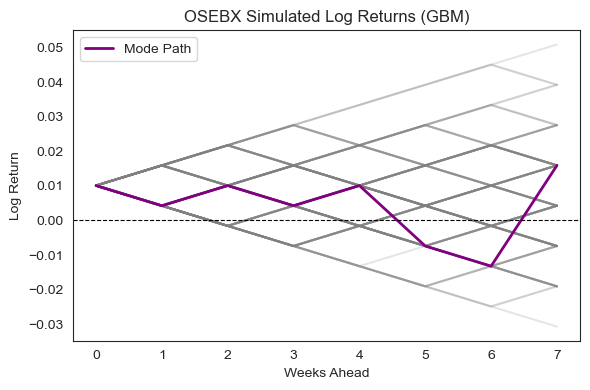

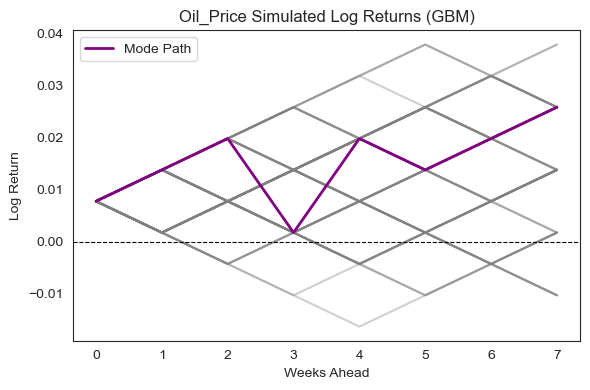

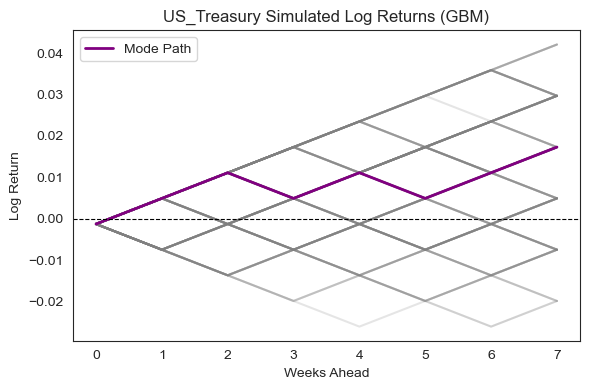

In [31]:
np.random.seed(42)  # You can choose any integer seed


# The data we use for simulation
datasets = {
    'OSEBX': osebx.copy(),
    'Oil_Price': oil_prices.copy(),
    'US_Treasury': us_treasury.copy()
}

target_date = pd.to_datetime('2024-12-31') # Simuation starting period, the same as the start of the testing period
n_steps = 8 # Simulate 8 weeks ahead, equivalent to the prediction period 
n_simulations = 1000 
dt = 1
lookback_for_p = 16  # We look 16 weeks back to find p_up for each exogeneous variables

# Different volatility of the variables makes different lookback periods necessarry
feature_settings = {
    'OSEBX': {'lookback_weeks': 8},
    'Oil_Price': {'lookback_weeks': 4}, # Oil price is volatile, hence the lookback period is shorter
    'US_Treasury': {'lookback_weeks': 16}
}

# Dictionary for storing simulated paths 
mode_paths = {}

# Simulating paths for each exogeneous variable
for name, df in datasets.items():
    settings = feature_settings[name]
    lookback = settings['lookback_weeks']

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]

    closest_idx = df.index.get_indexer([target_date], method='nearest')[0]  # Closest valid start date, in case missing 
    closest_date = df.index[closest_idx]

    # Estimate volatility from recent returns
    returns_volatility = df.loc[closest_date - pd.DateOffset(weeks=lookback):closest_date]['Log_Returns']
    mu, sigma = returns_volatility.mean(), returns_volatility.std()
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Estimate p_up from 16 weeks of data 
    returns_direction = df.loc[closest_date - pd.DateOffset(weeks=lookback_for_p):closest_date]['Log_Returns']
    p_up = (returns_direction > 0).mean()

    # Starting value
    start_value = df.iloc[closest_idx]['Log_Returns']

    # Simulate paths
    simulated = np.zeros((n_simulations, n_steps))
    for i in range(n_simulations):
        path = [start_value]
        for _ in range(1, n_steps):
            step = np.log(u) if np.random.rand() < p_up else np.log(d)
            path.append(path[-1] + step)
        simulated[i] = path

    # Mode path
    mode_path = mode(simulated, axis=0, keepdims=False)[0].flatten()
    mode_paths[name] = (mode_path, simulated)

# Plotting simulations of log returns of OSEBX, oil price and US Treasury bonds 
for name, (mode_path, simulated) in mode_paths.items():
    plt.figure(figsize=(6, 4))
    for i in range(100):
        plt.plot(range(n_steps), simulated[i], color='gray', alpha=0.2)
    plt.plot(range(n_steps), mode_path, color='purple', linewidth=2, label='Mode Path')
    plt.title(f'{name} Simulated Log Returns (GBM)')
    plt.xlabel('Weeks Ahead')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.ylabel('Log Return')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 3. Fitting the data to optimal ARIMAX model, and plotting results of 8 week prediction

                                SARIMAX Results                                
Dep. Variable:     Aker_BP_Log_Returns   No. Observations:                  574
Model:                SARIMAX(1, 1, 1)   Log Likelihood                1920.481
Date:                 Thu, 03 Apr 2025   AIC                          -3828.962
Time:                         14:52:46   BIC                          -3802.878
Sample:                     01-06-2014   HQIC                         -3818.786
                          - 12-30-2024                                         
Covariance Type:                   opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Oil_Price       0.3011      0.031      9.789      0.000       0.241       0.361
OSEBX           1.5612      0.060     26.158      0.000       1.444       1.678
US_Treasury    -0.0912      0.018     -5

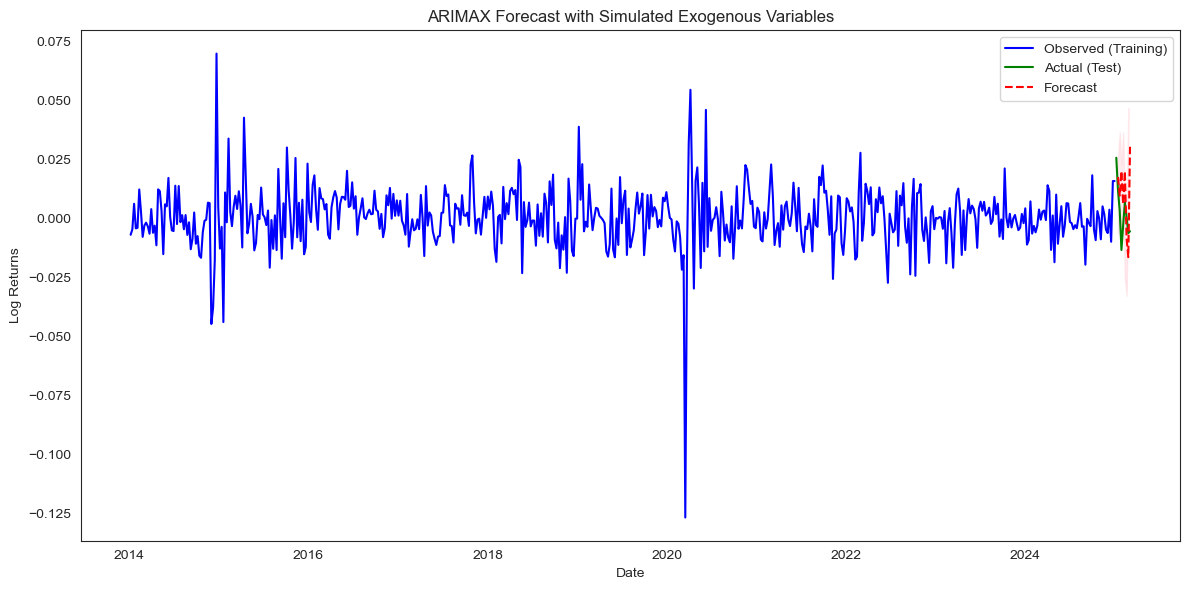

In [ ]:

sns.set_style("white") # Defining style of plot 

# We use the merged data of all the log returns 
merged_df.index = pd.to_datetime(merged_df.index)
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
merged_df = merged_df.asfreq('W-MON')
merged_df.ffill(inplace=True) # Handle missing values   
merged_df.bfill(inplace=True) # Handle missing values 

train_end = pd.to_datetime('2024-12-31') 
train_data = merged_df.loc[:train_end] # We train on data from start of dataset (2014) until this 2024-12-31
test_data = merged_df.loc[train_end:] # We predict/test on remainder of dataset 

# We define the dependent and independent variables 
Y_train = train_data['Aker_BP_Log_Returns'] 
X_train = train_data[['Oil_Price', 'OSEBX', 'US_Treasury']]


order = (1,1,1)
model = SARIMAX(Y_train, exog=X_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

print(results.summary())

# We define the dates for forecasting
forecast_dates = pd.date_range(start=train_end + pd.Timedelta(weeks=1), periods=n_steps, freq='W-MON')

# We use the simulated values from step 2 in the prediction 
simulated_exog = pd.DataFrame(index=forecast_dates)
for var in ['Oil_Price', 'OSEBX', 'US_Treasury']:
    simulated_exog[var] = mode_paths[var][0]  # mode path

# Initializing list for storing predicted values and confidence intervals 
forecast_values, forecast_ci_lower, forecast_ci_upper = [], [], []

forecast = results.get_forecast(steps=n_steps, exog=simulated_exog)


forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean.values,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
}, index=forecast_dates)


plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data['Aker_BP_Log_Returns'], label='Observed (Training)', color='blue')
sns.lineplot(x=test_data.index, y=test_data['Aker_BP_Log_Returns'], label='Actual (Test)', color='green')
sns.lineplot(x=forecast_df.index, y=forecast_df['Forecast'], linestyle='dashed', color='red', label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.title('ARIMAX Forecast with Simulated Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


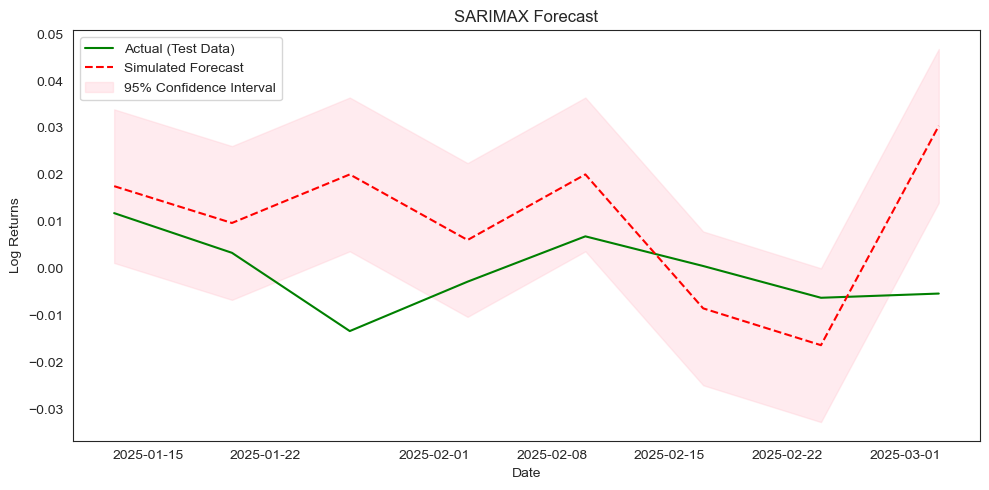

In [33]:
# Only the test period is plotted


# Rebuild forecast_df to ensure alignment
forecast = results.get_forecast(steps=n_steps, exog=simulated_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Force correct datetime index
forecast_mean.index = forecast_dates
forecast_ci.index = forecast_dates

# Reassign forecast_df with proper alignment
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
}, index=forecast_dates)

# Align actuals with forecast
actual_values = merged_df.reindex(forecast_df.index)['Aker_BP_Log_Returns']
valid_idx = actual_values.notna() & forecast_df['Forecast'].notna()
actual_values = actual_values[valid_idx]
forecast_series = forecast_df['Forecast'][valid_idx]

# --- Plot ---
plt.figure(figsize=(10, 5))

# Actual values
plt.plot(actual_values.index, actual_values.values, label='Actual (Test Data)', color='green')

# Forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], linestyle='dashed', color='red', label='Simulated Forecast')

# Confidence Interval (aligned)
plt.fill_between(
    forecast_df.index,
    forecast_df['Lower CI'],
    forecast_df['Upper CI'],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


# 4. Performance metrics


In [34]:
# Metrics using imported functions 
mse = mean_squared_error(actual_values, forecast_series)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, forecast_series)
max_err = max_error(actual_values, forecast_series)

print(f"Metrics are: \n mse: {mse} \n rmse: {rmse} \n mae: {mae} \n max_err: {max_err}")


Metrics are: 
 mse: 0.00036284962994701333 
 rmse: 0.019048612284022513 
 mae: 0.015307309564889921 
 max_err: 0.03574467250793138
